# Preamble

In [1]:
from utils.visualization import *
from utils.utils import *
from utils.network import *

from collections import defaultdict
import subprocess
import re
import copy
import random

In [11]:
standarize_plot_parameters()

# Analysis

This notebook produces Fig. 2 and Fig. 3.

## Fig 2.

The figure in the paper is the analytical result. Below we produce that result, both using Eq. (5), and also numerically.

### Analytical

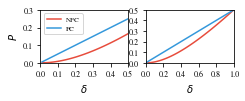

In [30]:
def p_fc(delta, r):
    """Probability of switching layer with full coupling (FC)."""
    return 0.5 * delta * r

def p_nfc(delta, r, N, rho=1):
    """Probability of switching layer with neighborhood flow coupling (NFC)."""
    return delta * r * ((rho * N * delta - 1) * 1.0 / ((rho * N * delta - 1) + (N - 1)))



N = 100                              # Number of points to evaluate in
r = 1.0                              # Relax rate
deltas = np.linspace(1.0 / N, 1, N)  # Delta grid
rho = 1.0                            # Link density

# Compute P_NFC and P_FC for deltas
P_FC, P_NFC = [], []
for delta in deltas:
    P_FC.append(p_fc(delta, r))
    P_NFC.append(p_nfc(delta, r, N, rho))

# Plot
plt.figure()

plt.subplot(2, 2, 1)
plt.plot(deltas, P_NFC, label="NFC", c="#e74c3c")
plt.plot(deltas, P_FC, label="FC", c="#3498db")
plt.xlabel("$\delta$"); plt.ylabel("$P$")
plt.xlim(0, 0.5); plt.ylim(0, 0.3)
plt.xticks(np.linspace(0, 0.5, 6))
plt.yticks(np.linspace(0, 0.3, 4))
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(deltas, P_NFC, c="#e74c3c")
plt.plot(deltas, P_FC, c="#3498db")
plt.xlabel("$\delta$")
plt.xlim(0, 1); plt.ylim(0, 0.5)
plt.xticks(np.linspace(0, 1.0, 6))
plt.yticks(np.linspace(0, 0.5, 6))

plt.savefig("figures/fig2a.pdf")
plt.show()

### Numerical

In [15]:
def run_FC(pid):
    subprocess.call([
        "Infomap",
        "tmp/input/network%d.net" % pid,
        "tmp/output",
        "-i", "multiplex",
        "--multiplex-relax-rate", "1.0",
        "--pajek",
        "-z"
    ])
    
def run_NFC(pid):
    subprocess.call([
        "Infomap",
        "tmp/input/network%d.net" % pid,
        "tmp/output",
        "-i", "multiplex",
        "--multiplex-js-relax-rate", "1.0",
        "--pajek",
        "-z"
    ])
    
def two_overlap_benchmark_model(N, m):
    """Create two communities of size `N` that overlap by `m` nodes.

    Two communities each contain `N` nodes and overlap my `m` nodes. All
    nodes in one layer are connected and we stack layers vertically. Examples:

    N=5, m=1:          |  N=5, m=2:        |  N=3, m=2
            o o o o o  |        o o o o o  |    o o o
    o o o o o          |  o o o o o        |  o o o

    Input
    -----
    N : int
        Number of nodes in each community
    m : int
        Number of overlapping nodes between the two communities
    """
    # Create both layers, initially identical
    first_layer = np.arange(0, N)
    second_layer = np.arange(N-m, 2*N - m)

    # Produce multilayer state node label map
    partition = defaultdict(lambda: defaultdict(list))
    for l, nodes in enumerate([first_layer, second_layer]):
        for n in nodes:
            partition[l][l].append(n)

    return default_to_regular(partition)

def P(pid):
    """Compute fraction of weight distributed on interlayer links."""
    with open("tmp/output/network%d.net" % pid) as fp:
        net = fp.read()

    intralayer_weight = 0
    interlayer_weight = 0
    for l in re.findall(r"\d+ \d+ \d+ \d+ \d.*\d*", net):
        l = map(eval, l.split())
        if l[0] == l[2]:
            intralayer_weight += l[4]
        if l[0] != l[2]:
            interlayer_weight += l[4]

    return interlayer_weight / (intralayer_weight + interlayer_weight)

N = 10
deltas = np.linspace(1.0 / N, 1, N)
ms = map(int, N * deltas)
sparse_frac = 1

a_nu, b_nu = [], []
for m in ms:
    two_layer_partition = two_overlap_benchmark_model(N, m)

    # Format as pajek
    network = convert_to_pajek(two_layer_partition, sparse_frac)

    # Save it
    pid_FC, pid_NFC = [np.random.randint(1, 1e9) for _ in range(2)]
    with open("tmp/input/network%d.net" % pid_FC, 'w') as fp:
        fp.write(network)
    with open("tmp/input/network%d.net" % pid_NFC, 'w') as fp:
        fp.write(network)
        
    run_FC(pid_FC)
    run_NFC(pid_NFC)
    
    a_nu.append(P(pid_FC))
    b_nu.append(P(pid_NFC))
    
    subprocess.call(["rm", "tmp/input/network%d.net" % pid_FC, "tmp/output/network%d.net" % pid_FC, "tmp/output/network%d.tree" % pid_FC])
    subprocess.call(["rm", "tmp/input/network%d.net" % pid_NFC, "tmp/output/network%d.net" % pid_NFC, "tmp/output/network%d.tree" % pid_NFC])

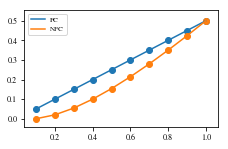

In [23]:
plt.figure()
plt.scatter(deltas, a_nu)
plt.plot(deltas, a_nu, label="FC")
plt.scatter(deltas, b_nu)
plt.plot(deltas, b_nu, label="NFC")
plt.legend()
plt.savefig("figures/fig2b.pdf")
plt.show()

## Fig. 3

In [5]:
def overlap_benchmark_model(N, C, d=1, swaps=50):
    """Create an instance of the overlap benchmark model.
    """
    # Create both layers, initially identical
    first_layer = np.array_split(shuffle_list(range(N)), C)
    second_layer = copy.deepcopy(first_layer)

    # Perform 1-50 edge swaps in the second layer graph
    for _ in range(np.random.randint(1, swaps)):
        a, b = random.sample(range(C), 2)
        a_i, b_i = random.choice(range(len(second_layer[a]))), random.choice(range(len(second_layer[b])))
        a_v, b_v = second_layer[a][a_i], second_layer[b][b_i]
        second_layer[a][a_i] = b_v; second_layer[b][b_i] = a_v

    # Produce multilayer state node label map
    partition_true = defaultdict(lambda: defaultdict(list))
    for l, layer in enumerate([first_layer] + [second_layer] * ((d-1)*2 + 1)):
        for c, nodes in enumerate(layer):
            for n in nodes:
                partition_true[l][(l * C) % (2*C) + c].append(n)
                
    return default_to_regular(partition_true)

def com_match(nodes_i, nodes_j, layer_communities_sol):
    """Check whether two node sets are in the same community."""
    def _get_com(nodes_x, l):
        sim = dict()
        for c, nodes in layer_communities_sol[l].items():
            sim[c] = len(set(nodes_x) & set(nodes))
        return max(sim.items(), key=lambda (k, v): v)[0]
    return _get_com(nodes_i, 0) == _get_com(nodes_j, 1)

def compute_overlap_and_merge(layer_communities_true, layer_communities_sol):
    """Compute overlap and merge (0 or 1) for layer-adjacent communities."""
    overlap, merge = [], []
    for c_i, nodes_i in layer_communities_true[0].items():
        for c_j, nodes_j in layer_communities_true[1].items():
            overlap.append(len(set(nodes_i) & set(nodes_j)))
            merge.append(com_match(nodes_i, nodes_j, layer_communities_sol))
    return overlap, merge

In [40]:
def result_statistics(overlap, merge):
    """For a set of overlaps and merge outcomes, compute the statistics and return plotable variables."""
    ds = defaultdict(list)
    for o, m in zip(overlap, merge):
        ds[o].append(m)
    x, y, e, c = zip(*sorted([
        (k, np.mean(v), np.std(v) / np.sqrt(len(v)), len(v)) for k, v in ds.items()
    ], key=lambda vals: vals[0]))
    return x, y, e, c

In [36]:
def run_simulation(N, C, sparse_frac):
    overlap_FC, merge_FC = [], []
    overlap_NFC, merge_NFC = [], []

    for _itr in range(1000):

        # Create partition
        partition_true = overlap_benchmark_model(N, C, swaps=2000)
        network_pajek = convert_to_pajek(partition_true, sparse_frac=sparse_frac)

        # Produce Infomap solution with full coupling
        random_FC = np.random.randint(0, 1000000)
        communities_FC, partition_FC, node_flow_FC, community_flow_FC = Infomap(
            network_pajek,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.3',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '-z',
            '--two-level',
            'pid%d' % random_FC
        )

        # Produce Infomap solution with neighborhood flow coupling
        random_NFC = np.random.randint(0, 1000000)
        communities_NFC, partition_NFC, node_flow_NFC, community_flow_NFC = Infomap(
            network_pajek,
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.3',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '-z',
            '--two-level',
            'pid%d' % random_NFC
        )

        # Compute overlap and merge
        overlap_FC_iter, merge_FC_iter = compute_overlap_and_merge(partition_true, partition_FC) 
        overlap_NFC_iter, merge_NFC_iter = compute_overlap_and_merge(partition_true, partition_NFC) 

        # Record computed values
        overlap_FC.extend(overlap_FC_iter)
        merge_FC.extend(merge_FC_iter)
        overlap_NFC.extend(overlap_NFC_iter)
        merge_NFC.extend(merge_NFC_iter)
        
    return overlap_FC, merge_FC, overlap_NFC, merge_NFC

overlap_FC, merge_FC, overlap_NFC, merge_NFC = run_simulation(N=500, C=50, sparse_frac=1)
overlap_FC_s, merge_FC_s, overlap_NFC_s, merge_NFC_s = run_simulation(N=500, C=50, sparse_frac=0.25)

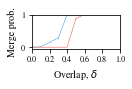

In [43]:
plt.figure()

plt.subplot(3, 2, 1)

# Rho = 1
x_FC, y_FC, e_FC, _ = result_statistics(overlap_FC, merge_FC)
x_NFC, y_NFC, e_NFC, _ = result_statistics(overlap_NFC, merge_NFC)
plt.errorbar(x_FC, y_FC, e_FC, c="#3498db", lw=0.5)
plt.errorbar(x_NFC, y_NFC, e_NFC, c="#e74c3c", lw=0.5)

plt.xlabel("Overlap, $\delta$")
plt.ylabel("Merge prob.")
plt.xlim(0, N/C)
plt.ylim(-0.05, 1.0)
plt.xticks(range(0, N/C+1, 2), np.arange(0, 1.2, 0.2))

plt.savefig("figures/fig3b.pdf")
plt.show()

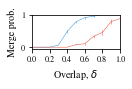

In [42]:
plt.figure()

plt.subplot(3, 2, 1)

# Rho = 0.25
x_FC_s, y_FC_s, e_FC_s, _ = result_statistics(overlap_FC_s, merge_FC_s)
x_NFC_s, y_NFC_s, e_NFC_s, _ = result_statistics(overlap_NFC_s, merge_NFC_s)
plt.errorbar(x_FC_s, y_FC_s, e_FC_s, c="#3498db", lw=0.5)
plt.errorbar(x_NFC_s, y_NFC_s, e_NFC_s, c="#e74c3c", lw=0.5)

plt.xlabel("Overlap, $\delta$")
plt.ylabel("Merge prob.")
plt.xlim(0, N/C)
plt.ylim(-0.05, 1.0)
plt.xticks(range(0, N/C+1, 2), np.arange(0, 1.2, 0.2))

plt.savefig("figures/fig3c.pdf")
plt.show()